# Create a MDAnalysis universe

In [1]:
import numpy as np
import os
import MDAnalysis as mda
import nmrformd as nmrmd

In [2]:
from matplotlib import pyplot as plt

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fontsize = 30
font = {'family': 'sans', 'color':  'black', 'weight': 'normal', 'size': fontsize}
myblue = [0/ 255, 150/255, 177/ 255]
lightgray = [0.1, 0.1, 0.1]
darkgray = [0.9, 0.9, 0.9]
myred= [255/ 255, 77/255, 77/ 255]

In [4]:
import sys
sys.path.append('../../examples/shared/')
from tools import figure_improvement, save_figure

In [6]:
R = np.linspace(myred[0], myblue[0], len(numbers_mol))
G = np.linspace(myred[1], myblue[1], len(numbers_mol))
B = np.linspace(myred[2], myblue[2], len(numbers_mol))
grad = np.vstack([R, G, B]).T

In [7]:
intra_correlation = []
intra_spectrum = []
inter_correlation = []
inter_spectrum = []
scalar_properties = []
for step in [1, 2, 4, 8, 16, 32]:
    u = mda.Universe("_N3000-gromacs/run.tpr",
                    "_N3000-gromacs/run.xtc")
    u.transfer_to_memory(step = step)
    group_i = u.select_atoms("type HW")
    dt = np.round(u.trajectory.dt,1)
    # Run NMRforMD
    print("steps =", step, ", dt =", dt)
    nmr_intra = nmrmd.NMR(u, group_i, isotropic=True, type_analysis="intra_molecular", number_i=100)
    T1_intra = np.round(nmr_intra.T1,2)
    T1_intra_av = np.round(np.mean(np.round(1/nmr_intra.R1[:10],2)),2)
    intra_spectrum.append(np.vstack([nmr_intra.f, nmr_intra.R1]))
    intra_correlation.append(np.vstack([nmr_intra.t, nmr_intra.gij[0]]))
    nmr_inter = nmrmd.NMR(u, group_i, isotropic=True, type_analysis="inter_molecular", number_i=100)
    T1_inter = np.round(nmr_inter.T1,2)
    T1_inter_av = np.round(np.mean(np.round(1/nmr_inter.R1[:10],2)),2)
    print(f"The NMR relaxation time is T1-inter = {T1_inter_av} s, and T1-inter = {T1_intra_av} s")
    inter_spectrum.append(np.vstack([nmr_inter.f, nmr_inter.R1]))
    inter_correlation.append(np.vstack([nmr_inter.t, nmr_inter.gij[0]]))
    scalar_properties.append([step, T1_intra, T1_intra_av, T1_inter, T1_inter_av])
    print("-------------------------------------------------------------------")
    np.savetxt("dumping-frequency-evaluation/intra_spectrum"+str(dt)+".dat", np.vstack([nmr_intra.f, nmr_intra.R1]).T)
    np.savetxt("dumping-frequency-evaluation/inter_spectrum"+str(dt)+".dat", np.vstack([nmr_inter.f, nmr_inter.R1]).T)
    np.savetxt("dumping-frequency-evaluation/intra_correlation"+str(dt)+".dat", np.vstack([nmr_intra.t, nmr_intra.gij[0]]).T)
    np.savetxt("dumping-frequency-evaluation/inter_correlation"+str(dt)+".dat", np.vstack([nmr_inter.t, nmr_inter.gij[0]]).T)

steps = 1 , dt = 1.0


16.0

In [8]:
u.trajectory.n_frames

1001

In [42]:
intra_correlation = []
intra_spectrum = []
inter_correlation = []
inter_spectrum = []
scalar_properties = []
for number_mol in numbers_mol:
    u = None
    data_lammps = "_N"+str(number_mol)+"-lammps/"
    data_gromacs = "_N"+str(number_mol)+"-gromacs/"
    if os.path.exists(data_lammps+"topology.data"):
        u = mda.Universe(data_lammps+"topology.data", data_lammps+"traj.xtc")
        group_i = u.select_atoms("type 2")
        folder = data_lammps
    elif os.path.exists(data_gromacs+"run.tpr"):
        u = mda.Universe(data_gromacs+"run.tpr", data_gromacs+"run.xtc")
        group_i = u.select_atoms("type HW")
        folder = data_gromacs
    if u is not None:
        timestep = np.int32(u.trajectory.dt)
        total_time = np.int32(u.trajectory.totaltime)
        n_molecules = u.atoms.n_residues
        assert n_molecules == number_mol
        v_box = np.round(np.prod(u.dimensions[:3]) / 1000,1)
        print(f"The number of water molecules is {n_molecules}")
        print("--------------------------------")
        # Run NMRforMD
        nmr_intra = nmrmd.NMR(u, group_i, isotropic=True, type_analysis="intra_molecular", number_i=100)
        T1_intra = np.round(nmr_intra.T1,2)
        T1_intra_av = np.mean(np.round(1/nmr_intra.R1[:10],2))
        print(f"The NMR relaxation time is T1-intra = {T1_intra_av} s")
        intra_spectrum.append(np.vstack([nmr_intra.f, nmr_intra.R1]))
        intra_correlation.append(np.vstack([nmr_intra.t, nmr_intra.gij[0]]))
        nmr_inter = nmrmd.NMR(u, group_i, isotropic=True, type_analysis="inter_molecular", number_i=100)
        T1_inter = np.round(nmr_inter.T1,2)
        T1_inter_av = np.mean(np.round(1/nmr_inter.R1[:10],2))
        print(f"The NMR relaxation time is T1-inter = {T1_inter_av} s")
        inter_spectrum.append(np.vstack([nmr_inter.f, nmr_inter.R1]))
        inter_correlation.append(np.vstack([nmr_inter.t, nmr_inter.gij[0]]))
        scalar_properties.append([number_mol, v_box, T1_intra, T1_intra_av, T1_inter, T1_inter_av])
        print("--------------------------------")
        print("--------------------------------")
        print("--------------------------------")
        if u.trajectory.n_frames == 4001:
            np.savetxt(folder+"intra_spectrum.dat", np.vstack([nmr_intra.f, nmr_intra.R1]).T)
            np.savetxt(folder+"inter_spectrum.dat", np.vstack([nmr_inter.f, nmr_inter.R1]).T)
            np.savetxt(folder+"intra_correlation.dat", np.vstack([nmr_intra.t, nmr_intra.gij[0]]).T)
            np.savetxt(folder+"inter_correlation.dat", np.vstack([nmr_inter.t, nmr_inter.gij[0]]).T)

The number of water molecules is 25
--------------------------------
Note : number_i is larger than the number of atoms in group target i
-> All the atoms of the group i have been selected
The NMR relaxation time is T1-intra = 10.237 s
Note : number_i is larger than the number of atoms in group target i
-> All the atoms of the group i have been selected
The NMR relaxation time is T1-inter = 11.449 s
--------------------------------
--------------------------------
--------------------------------
The number of water molecules is 34
--------------------------------
Note : number_i is larger than the number of atoms in group target i
-> All the atoms of the group i have been selected


/home/simon/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:241: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


11.449

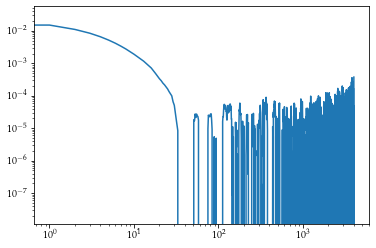

In [19]:
plt.loglog(nmr_inter.t, nmr_inter.gij[0])

In [28]:
np.mean(nmr_intra.R1[:10])

0.12396093837407296

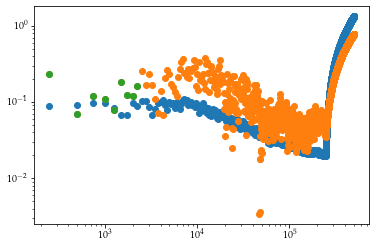

In [27]:
plt.loglog(nmr_inter.f, nmr_inter.R1, 'o')
plt.loglog(nmr_inter.f, nmr_intra.R1, 'o')    
plt.loglog(nmr_inter.f[:10], nmr_intra.R1[:10], 'o')


In [9]:
inter_correlation

[]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


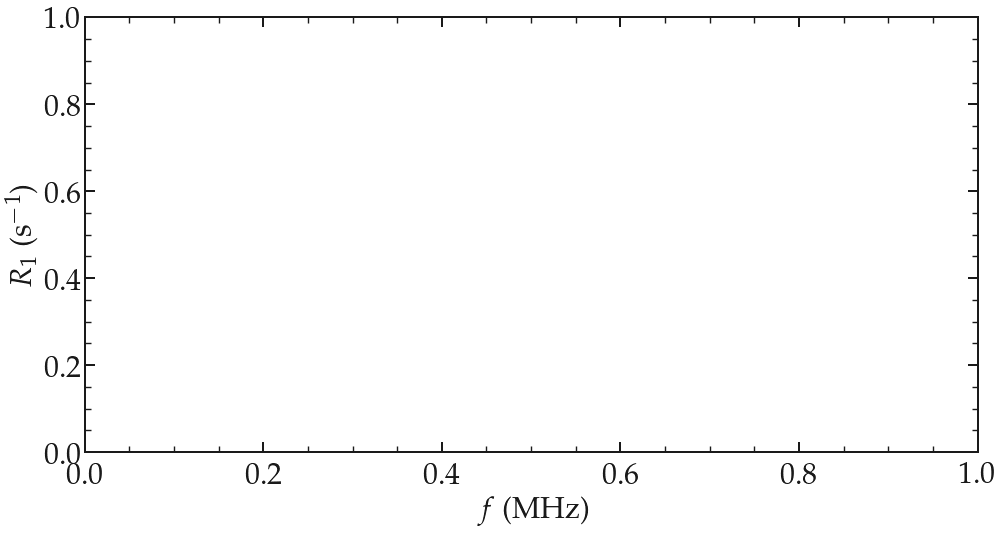

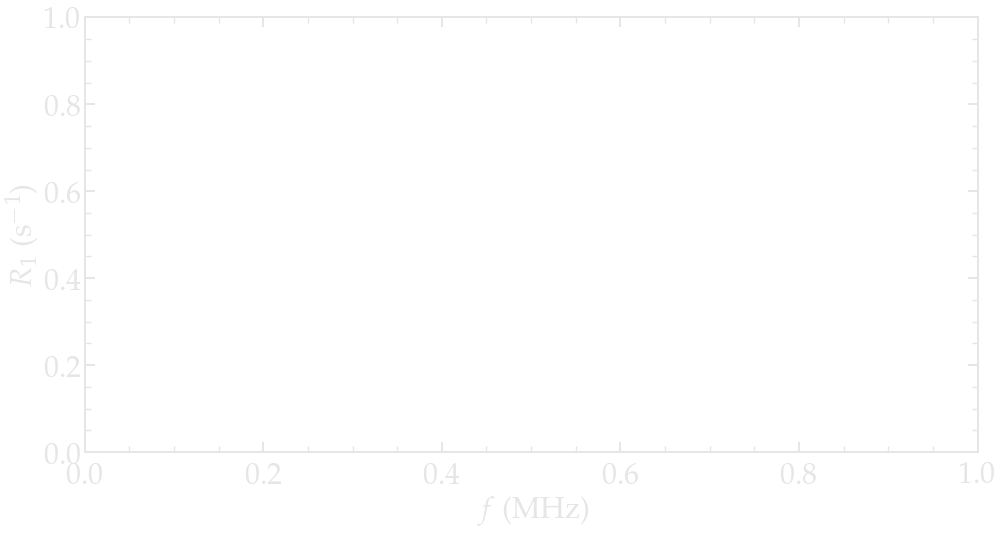

In [8]:
for mode, mygray in zip(['light', 'dark'], [lightgray, darkgray]):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(111)
    cpt = 0
    for inter, intra in zip(inter_correlation, intra_correlation):
        ax1.loglog(inter[0], inter[1], 'o', markersize=8, color=grad[cpt])
        ax1.loglog(intra[0], intra[1], 's', markersize=8, color=grad[cpt])
        cpt += 1
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$f$ (MHz)", ylabel=r'$R_1$ (s$^{-1}$)') #,
                       #xlim=(5e2, 3e5), ylim=(0.001, 10))
    #save_figure(plt, fig, mode, name='T1')

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)

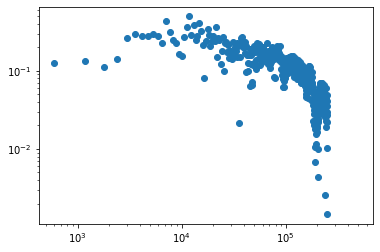

In [24]:
plt.loglog(nmr_result.f, nmr_result.R1, 'o')

# Extract results

In [ ]:
T1 = np.round(nmr_result.T1,2)
print(f"NMR relaxation time T1 = {T1} s")

#### Plot the spectrum

Note: here, one figure is made for the light mode of the documentation, the other one for the dark mode

In [22]:
from matplotlib import pyplot as plt

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fontsize = 30
font = {'family': 'sans', 'color':  'black', 'weight': 'normal', 'size': fontsize}
myblue = [0/ 255, 150/255, 177/ 255]
lightgray = [0.1, 0.1, 0.1]
darkgray = [0.9, 0.9, 0.9]
myred= [255/ 255, 77/255, 77/ 255]

In [ ]:
import sys
sys.path.append('../shared/')
from tools import figure_improvement, save_figure

In [ ]:
f_1 = 260
for mode, mygray in zip(['light', 'dark'], [lightgray, darkgray]):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(111)
    ax1.loglog(nmr_result.f[:-f_1], 1/nmr_result.R1[:-f_1], 'o', markersize=8, color=myblue)
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$f$ (MHz)", ylabel=r'$T_1$ (s)',
                       xlim=(5e2, 3e5), ylim=(1, 100))
    save_figure(plt, fig, mode, name='T1')

# Plot the correlation function

In [ ]:
for mode, mygray in zip(['light', 'dark'], [lightgray, darkgray]):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(111)
    ax1.loglog(nmr_result.t, nmr_result.gij[0]/nmr_result.gij[0][0], 'o', markersize=8, color=myblue)
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$t$ (ps)", ylabel=r'$G^{(0)} (t) / G^{(0)} (0)$',
                       xlim=(1, 200), ylim=(0.0001, 1))
    save_figure(plt, fig, mode, name='Gij')

# Intra/Inter motion

In [ ]:
nmr_result_intra = nmrmd.NMR(u, group_i, type_analysis="intra_molecular", number_i=0)
nmr_result_inter = nmrmd.NMR(u, group_i, type_analysis="inter_molecular", number_i=20)

In [ ]:
f_1 = 250
for mode, mygray in zip(['light', 'dark'], [lightgray, darkgray]):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(111)
    ax1.loglog(nmr_result.f[:-f_1], nmr_result.R1[:-f_1], 'o', markersize=8, color=myblue, label="Total")
    ax1.loglog(nmr_result_intra.f[:-f_1], nmr_result_intra.R1[:-f_1], 'o', markersize=8, color=myred, label="Intra-molecular")
    ax1.loglog(nmr_result_inter.f[:-f_1], nmr_result_inter.R1[:-f_1], 'o', markersize=8, color=mygray, label="Inter-molecular")
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$f$ (MHz)", ylabel=r'$R_1$ (s$^{-1}$)',
                       xlim=(5e2, 3e5), ylim=(0.01, 1))
    save_figure(plt, fig, mode, name='R1-intra-inter')

In [ ]:
for mode, mygray in zip(['light', 'dark'], [lightgray, darkgray]):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(111)
    ax1.loglog(nmr_result.t, nmr_result.gij[0]/nmr_result.gij[0][0], 'o', markersize=8, color=myblue, label="Total")
    ax1.loglog(nmr_result_intra.t, nmr_result_intra.gij[0]/nmr_result.gij[0][0], 'o', markersize=8, color=myred, label="Intra-molecular")
    ax1.loglog(nmr_result_inter.t, nmr_result_inter.gij[0]/nmr_result.gij[0][0], 'o', markersize=8, color=mygray, label="Inter-molecular")
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$t$ (ps)", ylabel=r'$G^{(0)} (t) / G^{(0)} (0)$',
                       xlim=(1, 100), ylim=(0.0001, 1))
    save_figure(plt, fig, mode, name='Gij-intra-inter')

# Proportionality between $G^{m}$ functions

In [ ]:
nmr_aniso = nmrmd.NMR(u, group_i, number_i=80, isotropic=False)

In [ ]:
for mode, mygray in zip(['light', 'dark'], [lightgray, darkgray]):
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(111)
    ax1.loglog(nmr_aniso.t, nmr_aniso.gij[0]/nmr_aniso.gij[0][0], 'o', markersize=8, color=myblue, label="$G^{(0)}(t) / G^{(0)}(0)$")
    ax1.loglog(nmr_aniso.t, 6*nmr_aniso.gij[1]/nmr_aniso.gij[0][0], 'o', markersize=8, color=myred, label="$6 G^{(1)}(t) / G^{(0)}(0)$")
    ax1.loglog(nmr_aniso.t, 6*nmr_aniso.gij[2]/nmr_aniso.gij[0][0]/4, 'o', markersize=8, color=mygray, label="$6 G^{(2)}(t) / G^{0()}(0) / 4$")
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$t$ (ps)", ylabel=r'$G^{(m)} (t) / G^{(0)} (0)$',
                       xlim=(1, 100), ylim=(0.0001, 1))
    save_figure(plt, fig, mode, name='Gij-aniso')